## Tutorial5: Triple omics Vertical Integration with SpatialMOI

### 1.Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import SpatialMOSI

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

[1] "已设置北大阿里云镜像"


### 2. Load Data and Preprocess

In [2]:
adata_rna=sc.read('./Data/Dataset_triple/adata_RNA.h5ad')
adata_adt=sc.read('./Data/Dataset_triple/adata_ADT.h5ad')
adata_atac = sc.read('./Data/Dataset_triple/adata_ATAC.h5ad')

In [3]:
from SpatialMOSI.utils import lsi,clr_normalization
adata_rna.var_names_make_unique(join="++")
adata_adt.var_names_make_unique(join="++")
adata_atac.var_names_make_unique(join="++")
adata_rna.uns['adj']=SpatialMOSI.generate_spatial_graph(adata_rna, radius=0.2)
adata_rna.uns['edgecsl'] = SpatialMOSI.generate_csl_graph(adata_rna.n_obs, 5)
adata_adt.uns['edgecsl'] = adata_rna.uns['edgecsl']
adata_atac.uns['edgecsl'] = adata_rna.uns['edgecsl']
adata_adt.uns['adj'] = adata_rna.uns['adj']
adata_atac.uns['adj'] = adata_rna.uns['adj']
sc.pp.highly_variable_genes(adata_rna, flavor="seurat_v3", n_top_genes=5000)

adata_rna = adata_rna[:, adata_rna.var['highly_variable']]
adata_adt=clr_normalization(adata_adt)
lsi(adata_atac, use_highly_variable=False, n_components=51)

graph includs edges: 9940 average edges per node: 7.670
Negative spots selection completed!


In [4]:
adata_adt.uns['adj']=adata_rna.uns['adj']
adata_atac.uns['adj']=adata_rna.uns['adj']

In [5]:
adata_rna.obs['batch_name']='RNA'
adata_adt.obs['batch_name']='ADT'
adata_atac.obs['batch_name']='ATAC'

### 3. Train

In [21]:
from SpatialMOSI.triple import train_SpatialMOSI_triple
train_SpatialMOSI_triple(adata_rna, adata_adt, adata_atac, alpha=1,beta=0.5, n_epochs=1000, hidden_dims_2=[64, 30], chr=True, hidden_dims_3=[40, 30], verbose=True, device=used_device)

Spatial_MOSI_triple(
  (conv1_mod1): GATConv(1000, 512, heads=1)
  (conv2_mod1): GATConv(512, 30, heads=1)
  (conv1_mod2): GATConv(100, 64, heads=1)
  (conv2_mod2): GATConv(64, 30, heads=1)
  (conv1_mod3): GATConv(50, 40, heads=1)
  (conv2_mod3): GATConv(40, 30, heads=1)
  (atten_cross): AttentionLayer_triplet()
  (dec1_mod1): Linear(in_features=30, out_features=512, bias=True)
  (dec2_mod1): Linear(in_features=512, out_features=1000, bias=True)
  (dec1_mod2): Linear(in_features=30, out_features=64, bias=True)
  (dec2_mod2): Linear(in_features=64, out_features=100, bias=True)
  (dec1_mod3): Linear(in_features=30, out_features=40, bias=True)
  (dec2_mod3): Linear(in_features=40, out_features=50, bias=True)
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.66it/s]


### 4. Clustering

In [ ]:
sc.pp.neighbors(adata_rna, use_rep='omics', random_state=666)
sc.tl.louvain(adata_rna, random_state=666, key_added="louvain", resolution=0.3)

In [11]:
#label
df=pd.DataFrame(adata_rna.obsm['spfac'])
df.index=adata_rna.obs_names
df.columns = ['col1', 'col2', 'col3', 'col4' ]
def maptocl(row):
    if row['col1']>0.5:
        return 4
    elif row['col2']>0.5:
        return 3
    elif row['col3']>0.5:
        return 2
    elif row['col4']>0.5:
        return 1
    else: return 0
cluster = df.apply(maptocl,axis=1)

In [12]:
adata_rna.obs['cluster']=cluster
adata_rna.obs['cluster']

529     3
478     4
234     3
64      3
1087    2
       ..
956     0
734     0
1104    1
398     4
1190    2
Name: cluster, Length: 1296, dtype: int64

In [23]:
from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_rna.obs['cluster'], adata_rna.obs['louvain']))

mclust, ARI = 0.991


### 5. Visulization

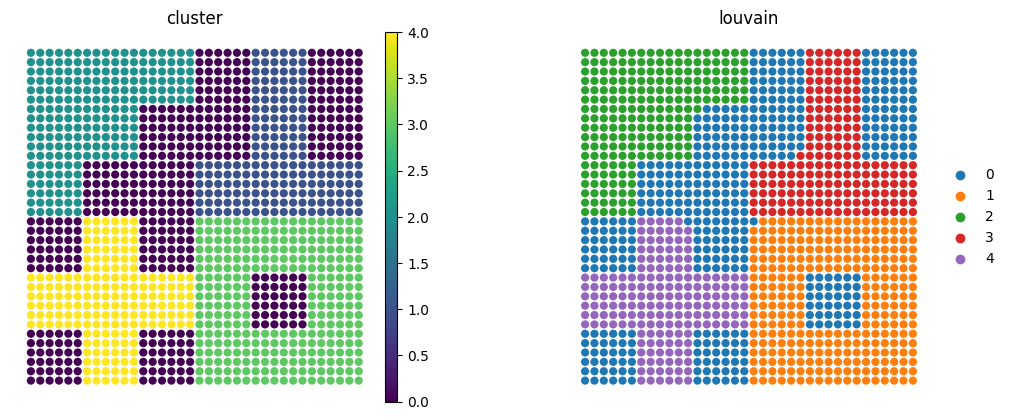

In [28]:
sc.pl.spatial(adata_rna,img_key=None, color=['cluster','louvain'], frameon=False,spot_size=0.1)

In [ ]:
sc.pp.neighbors(adata_rna, use_rep='omics', random_state=666)
sc.tl.umap(adata_rna, random_state=666)

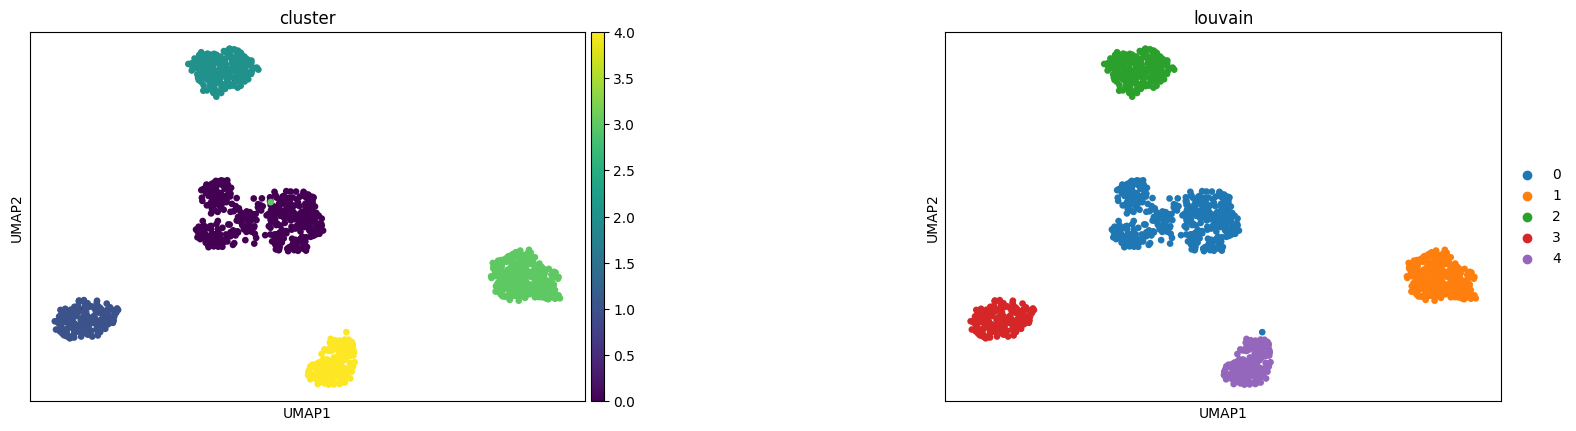

In [27]:
sc.pl.umap(adata_rna, color=['cluster' ,'louvain'], ncols=2, 
           wspace=0.5, show=True)